# Information Gain

In [2]:
import numpy as np
import pandas as pd

def calculate_entropy(data_subset: pd.DataFrame) -> float:
    """
    Calculates the entropy for a subset of data based on the 'target' column.

    Parameters:
    data_subset (pd.DataFrame): A subset of the dataset that includes the 'target' column.

    Returns:
    float: The calculated entropy value.
    """
    if data_subset.empty:
        return 0.0

    # Assume the last column or a column named 'target' is the class label.
    # We prioritize 'target' if it exists for clarity.
    target_column = data_subset.iloc[:, -1] if 'target' not in data_subset.columns else data_subset['target']

    # Calculate the frequency of each class
    class_counts = target_column.value_counts()
    total_samples = len(target_column)

    entropy = 0.0
    for count in class_counts:
        probability = count / total_samples
        # Avoid log(0) for probabilities of 0
        if probability > 0:
            entropy -= probability * np.log2(probability)
    return entropy

def calculate_information_gain(data: pd.DataFrame, feature_name: str, target_name: str = 'target') -> float:
    """
    Calculates the Information Gain for a given feature.

    Parameters:
    data (pd.DataFrame): The entire dataset.
    feature_name (str): The name of the feature for which to calculate Information Gain.
    target_name (str): The name of the target (class) column. Defaults to 'target'.

    Returns:
    float: The calculated Information Gain value.
    """
    # Entropy of the entire dataset
    total_entropy = calculate_entropy(data)

    # Get unique values for the feature
    feature_values = data[feature_name].unique()

    weighted_entropy = 0.0

    # Check if the feature is categorical (object/category dtype) or numerical
    if data[feature_name].dtype == 'object' or isinstance(data[feature_name].dtype, pd.CategoricalDtype):
        # Categorical Feature
        for value in feature_values:
            subset = data[data[feature_name] == value]
            weight = len(subset) / len(data)
            weighted_entropy += weight * calculate_entropy(subset)
    else:
        # Numerical/Continuous Feature
        # For continuous features, we need to find the best splitting threshold.
        # Candidate thresholds are midpoints between sorted unique values.
        sorted_values = sorted(feature_values)
        candidate_thresholds = [(sorted_values[i] + sorted_values[i+1]) / 2
                                for i in range(len(sorted_values) - 1)]

        best_split_entropy = float('inf') # Initialize with infinity to find the minimum

        if not candidate_thresholds: # If only one unique value for continuous feature
            return 0.0 # Cannot split, information gain is 0

        for threshold in candidate_thresholds:
            subset_left = data[data[feature_name] <= threshold]
            subset_right = data[data[feature_name] > threshold]

            if not subset_left.empty and not subset_right.empty:
                weight_left = len(subset_left) / len(data)
                weight_right = len(subset_right) / len(data)
                current_split_entropy = (weight_left * calculate_entropy(subset_left) +
                                         weight_right * calculate_entropy(subset_right))
                if current_split_entropy < best_split_entropy:
                    best_split_entropy = current_split_entropy
            elif subset_left.empty or subset_right.empty: # Avoids splits that result in empty subsets for meaningful IG
                 current_split_entropy = float('inf') # Penalize invalid splits

            if current_split_entropy < best_split_entropy:
                    best_split_entropy = current_split_entropy

        weighted_entropy = best_split_entropy # Use the best weighted entropy found

    information_gain = total_entropy - weighted_entropy
    return information_gain

def find_best_attribute(data: pd.DataFrame, target_name: str = 'target') -> tuple[str | None, float]:
    """
    Finds the best feature for splitting using Information Gain.

    Parameters:
    data (pd.DataFrame): The entire dataset.
    target_name (str): The name of the target (class) column.

    Returns:
    tuple: (Name of the best feature, its Information Gain value).
           Returns (None, 0.0) if no features are found or cannot be split.
    """
    features = [col for col in data.columns if col != target_name]
    if not features:
        return None, 0.0

    best_ig = -1.0 # Initialize to a value lower than any possible IG
    best_feature = None

    for feature in features:
        current_ig = calculate_information_gain(data, feature, target_name)
        if current_ig > best_ig:
            best_ig = current_ig
            best_feature = feature
    return best_feature, best_ig

# --- Usage Examples ---

# 1. Example with Categorical Data (Golf Play Classifier - famous example)
print("--- Example 1: Categorical Data (Golf Play) ---")
data_golf = pd.DataFrame({
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Windy': ['False', 'True', 'False', 'False', 'False', 'True', 'True', 'False', 'False', 'False', 'True', 'True', 'False', 'True'],
    'PlayGolf': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
})
# Rename the target column to 'target' for consistency
data_golf = data_golf.rename(columns={'PlayGolf': 'target'})


# Calculate initial entropy for the golf dataset
entropy_golf = calculate_entropy(data_golf)
print(f"Initial Entropy of Golf dataset: {entropy_golf:.4f}")

# Calculate Information Gain for each feature
features_golf = ['Outlook', 'Temperature', 'Humidity', 'Windy']
for feature in features_golf:
    ig = calculate_information_gain(data_golf, feature)
    print(f"Information Gain for '{feature}': {ig:.4f}")

# Find the best feature for golf
best_feature_golf, best_ig_golf = find_best_attribute(data_golf)
print(f"Best feature for Golf: '{best_feature_golf}' with Information Gain: {best_ig_golf:.4f}\n")


# 2. Example with Numerical Data (Disease Prediction with Age and Blood Pressure)
print("--- Example 2: Numerical Data (Disease Prediction) ---")
data_medical = pd.DataFrame({
    'Age': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    'BloodPressure': [120, 130, 140, 125, 135, 150, 160, 145, 155, 165],
    'target': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1] # 0: Healthy, 1: Diseased
})

# Calculate initial entropy for the medical dataset
entropy_medical = calculate_entropy(data_medical)
print(f"Initial Entropy of Medical dataset: {entropy_medical:.4f}")

# Calculate Information Gain for each feature
features_medical = ['Age', 'BloodPressure']
for feature in features_medical:
    ig = calculate_information_gain(data_medical, feature)
    print(f"Information Gain for '{feature}': {ig:.4f}")

# Find the best feature for medical data
best_feature_medical, best_ig_medical = find_best_attribute(data_medical)
print(f"Best feature for Medical: '{best_feature_medical}' with Information Gain: {best_ig_medical:.4f}\n")

--- Example 1: Categorical Data (Golf Play) ---
Initial Entropy of Golf dataset: 0.9403
Information Gain for 'Outlook': 0.2467
Information Gain for 'Temperature': 0.0292
Information Gain for 'Humidity': 0.1518
Information Gain for 'Windy': 0.0481
Best feature for Golf: 'Outlook' with Information Gain: 0.2467

--- Example 2: Numerical Data (Disease Prediction) ---
Initial Entropy of Medical dataset: 0.9710
Information Gain for 'Age': 0.9710
Information Gain for 'BloodPressure': 0.6100
Best feature for Medical: 'Age' with Information Gain: 0.9710



# Gini

In [4]:
import numpy as np
import pandas as pd

def calculate_gini_impurity(data_subset: pd.DataFrame) -> float:
    """
    Calculates the Gini Impurity for a subset of data based on the 'target' column.

    Parameters:
    data_subset (pd.DataFrame): A subset of the dataset that includes the 'target' column.

    Returns:
    float: The calculated Gini Impurity value.
    """
    if data_subset.empty:
        return 0.0

    # Assume the last column or a column named 'target' is the class label.
    target_column = data_subset.iloc[:, -1] if 'target' not in data_subset.columns else data_subset['target']

    class_counts = target_column.value_counts()
    total_samples = len(target_column)

    gini_impurity = 1.0
    for count in class_counts:
        probability = count / total_samples
        gini_impurity -= probability**2
    return gini_impurity

def calculate_gini_gain(data: pd.DataFrame, feature_name: str, target_name: str = 'target') -> float:
    """
    Calculates the Gini Gain (reduction in Gini Impurity) for a given feature.

    Parameters:
    data (pd.DataFrame): The entire dataset.
    feature_name (str): The name of the feature for which to calculate Gini Gain.
    target_name (str): The name of the target (class) column. Defaults to 'target'.

    Returns:
    float: The calculated Gini Gain value.
    """
    # Gini Impurity of the entire dataset before splitting
    total_gini_impurity = calculate_gini_impurity(data)

    feature_values = data[feature_name].unique()

    weighted_gini_impurity_after_split = 0.0

    if data[feature_name].dtype == 'object' or isinstance(data[feature_name].dtype, pd.CategoricalDtype):
        # Categorical Feature
        for value in feature_values:
            subset = data[data[feature_name] == value]
            weight = len(subset) / len(data)
            weighted_gini_impurity_after_split += weight * calculate_gini_impurity(subset)
    else:
        # Numerical/Continuous Feature
        # Find the best splitting threshold
        sorted_values = sorted(feature_values)
        candidate_thresholds = [(sorted_values[i] + sorted_values[i+1]) / 2
                                for i in range(len(sorted_values) - 1)]

        best_split_gini = float('inf') # Initialize with infinity to find the minimum weighted Gini

        if not candidate_thresholds: # If only one unique value for continuous feature
            return 0.0 # Cannot split, Gini Gain is 0

        for threshold in candidate_thresholds:
            subset_left = data[data[feature_name] <= threshold]
            subset_right = data[data[feature_name] > threshold]

            if not subset_left.empty and not subset_right.empty:
                weight_left = len(subset_left) / len(data)
                weight_right = len(subset_right) / len(data)
                current_split_gini = (weight_left * calculate_gini_impurity(subset_left) +
                                      weight_right * calculate_gini_impurity(subset_right))

                if current_split_gini < best_split_gini:
                    best_split_gini = current_split_gini
            elif subset_left.empty or subset_right.empty:
                # Penalize splits that result in empty subsets, making them less likely to be chosen.
                current_split_gini = float('inf')

            # Update best_split_gini even if it's inf from a penalized split, as long as it's the current best
            if current_split_gini < best_split_gini:
                best_split_gini = current_split_gini

        weighted_gini_impurity_after_split = best_split_gini # Use the best weighted Gini found

    gini_gain = total_gini_impurity - weighted_gini_impurity_after_split
    return gini_gain

def find_best_attribute_gini(data: pd.DataFrame, target_name: str = 'target') -> tuple[str | None, float]:
    """
    Finds the best feature for splitting using Gini Gain.

    Parameters:
    data (pd.DataFrame): The entire dataset.
    target_name (str): The name of the target (class) column.

    Returns:
    tuple: (Name of the best feature, its Gini Gain value).
           Returns (None, 0.0) if no features are found or cannot be split meaningfully.
    """
    features = [col for col in data.columns if col != target_name]
    if not features:
        return None, 0.0

    best_gini_gain = -1.0 # Initialize to a value lower than any possible Gini Gain
    best_feature = None

    for feature in features:
        current_gini_gain = calculate_gini_gain(data, feature, target_name)
        if current_gini_gain > best_gini_gain:
            best_gini_gain = current_gini_gain
            best_feature = feature
    return best_feature, best_gini_gain

# --- Usage Examples ---

# 1. Example with Categorical Data (Golf Play Classifier - famous example)
print("--- Example 1: Categorical Data (Golf Play) ---")
data_golf = pd.DataFrame({
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Windy': ['False', 'True', 'False', 'False', 'False', 'True', 'True', 'False', 'False', 'False', 'True', 'True', 'False', 'True'],
    'PlayGolf': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
})
# Rename the target column to 'target' for consistency
data_golf = data_golf.rename(columns={'PlayGolf': 'target'})


# Calculate initial Gini Impurity for the golf dataset
gini_golf = calculate_gini_impurity(data_golf)
print(f"Initial Gini Impurity of Golf dataset: {gini_golf:.4f}")

# Calculate Gini Gain for each feature
features_golf = ['Outlook', 'Temperature', 'Humidity', 'Windy']
for feature in features_golf:
    gg = calculate_gini_gain(data_golf, feature)
    print(f"Gini Gain for '{feature}': {gg:.4f}")

# Find the best feature for golf using Gini Gain
best_feature_golf_gini, best_gg_golf = find_best_attribute_gini(data_golf)
print(f"Best feature for Golf (Gini): '{best_feature_golf_gini}' with Gini Gain: {best_gg_golf:.4f}\n")


# 2. Example with Numerical Data (Disease Prediction with Age and Blood Pressure)
print("--- Example 2: Numerical Data (Disease Prediction) ---")
data_medical = pd.DataFrame({
    'Age': [25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    'BloodPressure': [120, 130, 140, 125, 135, 150, 160, 145, 155, 165],
    'target': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1] # 0: Healthy, 1: Diseased
})

# Calculate initial Gini Impurity for the medical dataset
gini_medical = calculate_gini_impurity(data_medical)
print(f"Initial Gini Impurity of Medical dataset: {gini_medical:.4f}")

# Calculate Gini Gain for each feature
features_medical = ['Age', 'BloodPressure']
for feature in features_medical:
    gg = calculate_gini_gain(data_medical, feature)
    print(f"Gini Gain for '{feature}': {gg:.4f}")

# Find the best feature for medical data using Gini Gain
best_feature_medical_gini, best_gg_medical = find_best_attribute_gini(data_medical)
print(f"Best feature for Medical (Gini): '{best_feature_medical_gini}' with Gini Gain: {best_gg_medical:.4f}\n")

--- Example 1: Categorical Data (Golf Play) ---
Initial Gini Impurity of Golf dataset: 0.4592
Gini Gain for 'Outlook': 0.1163
Gini Gain for 'Temperature': 0.0187
Gini Gain for 'Humidity': 0.0918
Gini Gain for 'Windy': 0.0306
Best feature for Golf (Gini): 'Outlook' with Gini Gain: 0.1163

--- Example 2: Numerical Data (Disease Prediction) ---
Initial Gini Impurity of Medical dataset: 0.4800
Gini Gain for 'Age': 0.4800
Gini Gain for 'BloodPressure': 0.3200
Best feature for Medical (Gini): 'Age' with Gini Gain: 0.4800



# Decision Tree


--- Scikit-learn Decision Tree ---
Scikit-learn Decision Tree Training Accuracy: 78.57%

--- Plotting Scikit-learn Decision Tree ---


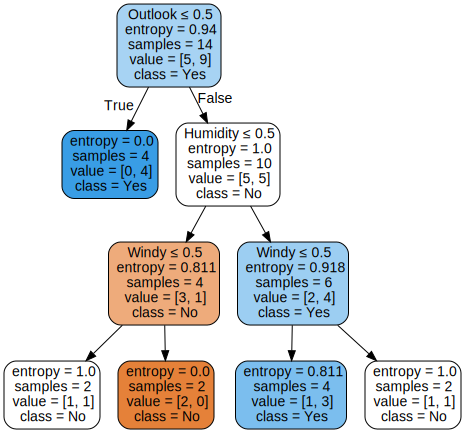

In [6]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import graphviz



data_golf_sklearn = pd.DataFrame({
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Windy': ['False', 'True', 'False', 'False', 'False', 'True', 'True', 'False', 'False', 'False', 'True', 'True', 'False', 'True'],
    'PlayGolf': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
})

le_outlook = LabelEncoder()
le_temp = LabelEncoder()
le_humidity = LabelEncoder()
le_windy = LabelEncoder()
le_playgolf = LabelEncoder()

data_golf_sklearn['Outlook_encoded'] = le_outlook.fit_transform(data_golf_sklearn['Outlook'])
data_golf_sklearn['Temperature_encoded'] = le_temp.fit_transform(data_golf_sklearn['Temperature'])
data_golf_sklearn['Humidity_encoded'] = le_humidity.fit_transform(data_golf_sklearn['Humidity'])
data_golf_sklearn['Windy_encoded'] = le_windy.fit_transform(data_golf_sklearn['Windy'])
data_golf_sklearn['PlayGolf_encoded'] = le_playgolf.fit_transform(data_golf_sklearn['PlayGolf'])

X_sklearn = data_golf_sklearn[['Outlook_encoded', 'Temperature_encoded', 'Humidity_encoded', 'Windy_encoded']]
y_sklearn = data_golf_sklearn['PlayGolf_encoded']

feature_names_sklearn = ['Outlook', 'Temperature', 'Humidity', 'Windy']
class_names_sklearn = le_playgolf.classes_.tolist() # ['No', 'Yes']

print("\n--- Scikit-learn Decision Tree ---")


dt_sklearn = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
dt_sklearn.fit(X_sklearn, y_sklearn)

predictions_sklearn = dt_sklearn.predict(X_sklearn)
accuracy_sklearn = accuracy_score(y_sklearn, predictions_sklearn)
print(f"Scikit-learn Decision Tree Training Accuracy: {accuracy_sklearn * 100:.2f}%")

print("\n--- Plotting Scikit-learn Decision Tree ---")

dot_data = export_graphviz(dt_sklearn,
                           out_file=None,
                           feature_names=feature_names_sklearn,
                           class_names=class_names_sklearn,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph